<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/Classification_LSTM_sub_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package

In [1]:
import re
from sklearn.utils import resample
import unicodedata
import torch
from sklearn.metrics import precision_recall_fscore_support as score
import torch.nn as nn
from torch.autograd import Variable
import seaborn as sns
from torch import optim
import torch.nn.functional as F
import pickle
import csv
import torch.utils.data as Data
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 

from tqdm import trange
import pandas as pd
import torchtext.vocab as Vocab
import collections
import numpy as np
import os
import os.path as path

from sklearn.model_selection import train_test_split
from torchtext import data, datasets
PAD, BOS, EOS = '<pad>', '<bos>', '<eos>'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import torch.optim as optim


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
data = pd.read_csv('/content/drive/My Drive/Data/EDA/aug_data/sub_twitter/test.tsv', sep='\t')
data.label.value_counts()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9052 entries, 0 to 9051
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  9052 non-null   object
 1   label     9052 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 141.6+ KB


## Data process

In [0]:
class Preprocessor():
    
  def __init__(self, data, max_seq_len, vocab):
    self.data = data
    self.max_seq_len = max_seq_len
    self.vocab = vocab
    self.PAD, self.BOS, self.EOS = '<pad>', '<bos>', '<eos>'
    self.all_tokens = []
    self.all_seqs = []

  def process_one_seq(self, seq_tokens):
    self.all_tokens.extend(seq_tokens) # add seq_tokens into one list, like extend the list, [..., seq_tokens].
    seq_tokens = [self.PAD] * (self.max_seq_len - len(seq_tokens)) + seq_tokens
    self.all_seqs.append(seq_tokens) # add seq_tokens become a list element, [...,[seq_tokens]].
      
  def build_data(self):
    if self.vocab:
      indices = [[self.vocab.stoi[w] for w in seq] for seq in self.all_seqs] # use its vocab_dic to represent the sentence. 
    else:
      tokens_dic = collections.Counter(self.all_tokens) 
      self.vocab = Vocab.Vocab(tokens_dic, specials=[self.PAD])
      indices = [[self.vocab.stoi[w] for w in seq] for seq in self.all_seqs] # use its vocab_dic to represent the sentence. 
    return torch.tensor(indices)
  
  @staticmethod
  def normalizeString(s):
    s = s.str.lower()
    s = s.str.replace(r"<br />",r" ")
    s = s.str.replace(r'(\W)(?=\1)', '')
    s = s.str.replace(r"([.!?])", r" \1")
    s = s.str.replace(r"[^a-zA-Z.!?]+", r" ")
    return s

  def read_data(self):
    df = self.data.copy()
    df = df.dropna()
    df['sentence'] = self.normalizeString(df['sentence'])
    df.reset_index(inplace=True, drop=True)
    k = len(df)
    target = []

    for line in range(k):
      in_seq_tokens = df['sentence'][line].split(' ')
      if len(in_seq_tokens) > self.max_seq_len - 1:
        continue
      self.process_one_seq(in_seq_tokens)
      target.append(df.label[line])

    in_data = self.build_data() # in_tokens is the list where contains every word, in_seqs is a list where its element are the sentence in French.

    return Data.TensorDataset(in_data, torch.tensor(target))

## Loading data, path and figure

In [0]:
class Loader():


  def path_setting(self, task_name, tech_name):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    
    return model_path, dataset_path, save_path

  @staticmethod
  def load_data(path_, FILE_NAME):

    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())
    # print('num_DA', num_DA)

    if FILE_NAME != 'oversampling':
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()
    
    else:
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling' and FILE_NAME != 'test':
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 

      df = pd.concat([df_train, df_over_samp]) 
    
    else: 
      pass

    df = df.sample(frac=1, replace=False, random_state=102)  
    return df

class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(10,5)) 
      # print('eval_name', eval_name)
      # print('eval_list', eval_list)
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')

      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(12, 5))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list): 

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(10, 5))
      barWidth = 0.07
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


## Model building

In [0]:
class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, num_direct,n_layers, drop_p=0.8):
    super().__init__()
    
    self.output_size = output_size
    self.n_layers = n_layers  
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=drop_p, bidirectional=num_direct, num_layers=n_layers)
    self.fc = nn.Linear(hidden_dim*2 , output_size)
    self.out = nn.Softmax(dim=1)

  
  def forward(self, x):
    # x (batch_size, seq_length) 
    x = self.embedding(x)
    output, hidden = self.lstm(x)
    # print('output', output.shape)
    output = self.fc(output[-1,:,:])
    #print('last output', output.shape)

    return output



In [0]:
# import numpy as np
# from sklearn.metrics import precision_recall_fscore_support
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
# y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
# a, b, c, _ = precision_recall_fscore_support(y_true, y_pred)
# a 

## Train

In [0]:
class Trainer():

  def __init__(self, model, batch_size, patient, learning_rate, N_EPOCHS, file_name):
    self.model = model
    self.batch_size = batch_size
    self.patient = patient
    self.lr = learning_rate
    self.epochs = N_EPOCHS
    self.file_name = file_name
  
  def binary_accuracy(self, pred, label_list):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = 0
    pred_list = pred.tolist()
    pred = [ten.index(max(ten)) for ten in pred.tolist()]
    correct = sum([1 for i in range(len(label_list)) if pred[i]==label_list[i]])
    precision, recall, fscore, _ = score(label_list, pred)
    # macro does not take minor class into account
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred, average='macro')
    # fscore_avg = list(fscore_avg)[0]
    
    self.acc = correct / len(label_list)
    return precision, recall, fscore


  def train(self, corpus_indices, corpus_indices_valid, corpus_indices_test, model_path):

    best_acc = 0
    best_loss = float('inf')
    loss = nn.CrossEntropyLoss()
    
    data_iter = Data.DataLoader(corpus_indices, self.batch_size, shuffle=True)
    data_iter_dev = Data.DataLoader(corpus_indices_valid , len(corpus_indices_valid), shuffle=True)
    data_iter_test = Data.DataLoader(corpus_indices_test , len(corpus_indices_test), shuffle=True)
    
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=0)
    # print('optimizer', optimizer)
    draw_train_loss = []
    draw_train_acc = []
    draw_val_loss = []
    draw_val_acc = []
    model_sel = []
    patient = 0
    precision_list = [0, 0, 0] 
    recall_list = [0, 0, 0] 
    fscore_list = [0, 0, 0] 
    fscore_avg_list = []
    precision_avg_list = []
    recall_avg_list = []
    
    for epoch in range(self.epochs):
      epoch_loss = []
      epoch_acc = []

      self.model.train()
      for batch in data_iter:
        batch = tuple(t.to(device) for t in batch)
        X, Y = batch[:][0], batch[:][1]
        y_pred = self.model(X.permute(1, 0)).squeeze(1)
        batch__train_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
        self.binary_accuracy(y_pred, Y.tolist())
        batch__train_loss.backward()
        optimizer.step()
        epoch_loss.append(batch__train_loss.item())
        epoch_acc.append(self.acc)
   
      val_loss = []    
      val_acc = []
      self.model.eval()
      
      for i, data_dev in enumerate(data_iter_dev):
        # print('i', i)
        data_dev = tuple(t.to(device) for t in data_dev)
        X, Y = data_dev[:][0], data_dev[:][1]
        y_pred = self.model(X.permute(1, 0)).squeeze(1)
        dev_loss = loss(y_pred, Y.to(device, dtype=torch.int64)).item()
        precision, recall, fscore = self.binary_accuracy(y_pred, Y.tolist())

      if best_acc < self.acc:
        best_acc = self.acc
        # patient = 0
      
      if best_loss > dev_loss:

        best_loss = dev_loss
        patient = 0
        model_sel = []  

      model_sel.append(self.model)
      patient += 1
      print('[epoch %d] train_loss: %.3f, train_acc:%.3f, val Loss: : %.6f, val_acc: %.3f' % 
            (epoch + 1, np.mean(epoch_loss), np.mean(epoch_acc), dev_loss, self.acc))
      
      if patient > self.patient:
        torch.save(self.model, path.join(model_path,'{}_lstm_cls.pt'.format(self.file_name)))
        break

      draw_train_loss.append(np.mean(epoch_loss)) #计算每个train epoch 的loss和acc 和 val的epoch的loss和acc
      draw_train_acc.append(np.mean(epoch_acc))
      draw_val_loss.append(dev_loss)
      draw_val_acc.append(self.acc)
    
    # torch.save(self.model, path.join(model_path,'{}_lstm_cls.pt'.format(self.file_name)))
    draw = utils(len(draw_train_acc))
    # print('train_loss', draw_train_loss, ' val_los', draw_val_loss)
    draw.acc_loss(draw_train_acc, draw_val_acc, draw_train_loss, draw_val_loss)

    # 将已经训练好的 model 加载数据    
    '''第一眼看上去是错的，但是其实这个 enumerate· 只有一个，也就是只迭代一次，为的是把 datatest 变成
    GPU 格式'''
    for i, data_test in enumerate(data_iter_test):
      
      data_test = tuple(t.to(device) for t in data_test)
      X, Y = data_test[:][0], data_test[:][1]
      y_pred = model_sel[0](X.permute(1, 0)).squeeze(1)
      test_loss = loss(y_pred, Y.to(device, dtype=torch.int64))
      precision, recall, fscore = self.binary_accuracy(y_pred, Y.tolist())

    # print('test data')
    # print('acc', self.acc, 'best_train_acc', best_acc)
    # print('best_train_acc', best_acc)
    # print('loss', test_loss.item(), 'best_train_loss', best_loss)

    # return self.model, self.acc, test_loss, precision, recall, fscore, fscore_avg
    return self.model, self.acc, test_loss.item(),  precision, recall, fscore, self.precision_avg, self.recall_avg, self.fscore_avg


## Execute

In [0]:
## 
def Execute(test_list, task_name, tech_name):
  # vocab_size = vocab_length + 1 #+1 for the padding 0
  output_size = 3 
  embedding_dim = 200
  hidden_dim = 128
  num_direct = True
  n_layers = 2
  acc_list = []
  batch_size = 32
  patient = 3
  N_EPOCHS = 20
  lr = 0.5e-5
  acc_list = []
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_avg_fs = []
  list_avg_prec = []
  list_avg_recall = []
  model_list = []

  loader = Loader()
  model_path, dataset_path, save_path = loader.path_setting(task_name, tech_name)
  # print('start to loading test dataset')
  df_dev = loader.load_data(save_path, 'dev')
  df_test = loader.load_data(save_path, 'test')
  # print('n.o df_test', len(df_test))
  if tech_name == 'Bert_ data augmentation-master' and task_name == 'rt-polaritydata':
    path_ = path.join(save_path, 'replacement')
  else:
    path_ = save_path

  for file_name in test_list:

    print('-' * 70)
    print('Start to make classification use the data : {}'.format(file_name))
    print('-' * 70)
    # DA and oversampling data"
    df_train = loader.load_data(path_, file_name) 
    df_vocab = pd.concat([df_train, df_dev], axis=0) # I didn't add the test dataset because I think it's happends that we could see the test dataset in practice.
    preprocessor = Preprocessor(df_vocab, 30, None)
    preprocessor.read_data() # in order to get a vocab including all words both in train and test set, preprocessor.vocab
    corpus_indices_train = Preprocessor(df_train, 30, preprocessor.vocab).read_data()
    corpus_indices_valid = Preprocessor(df_dev, 30, preprocessor.vocab).read_data()
    corpus_indices_test = Preprocessor(df_test, 30, preprocessor.vocab).read_data()
    model = SentimentRNN(len(preprocessor.vocab)+1, output_size, embedding_dim, hidden_dim, num_direct, n_layers)
    model.to(device)
    
    trainer = Trainer(model, batch_size, patient, lr, N_EPOCHS, file_name)
    model_, acc, loss, precision, recall, fscore, precision_avg, recall_avg, fscore_avg = trainer.train(corpus_indices_train,
                                                                         corpus_indices_valid, corpus_indices_test, model_path)
    print('-' * 70)
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)
    model_list.append(model_)
    acc_list.append(acc)
    loss_list.append(loss)

    list_avg_fs.append(fscore_avg)
    list_avg_prec.append(precision_avg)
    list_avg_recall.append(recall_avg)
  
  # model_test(model_list, corpus_indices_test, test_list)
  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)
  print('average recall', list_avg_recall)
  print('average fs', list_avg_fs)
  print('average precision', list_avg_prec)
  
  utils.draw_final({'loss': loss_list, 'accuracy': acc_list, 'recall_macro': list_avg_recall, 'precision_macro': list_avg_prec, 'fscore_macro': list_avg_fs}, test_list)
  utils.draw_other_final( {
                    
                    'precision_list': precision_list,
                    'recall': recall_list, 
                    'fscore': fscore_list, 
                    }, test_list)




## *EDA*

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.019, train_acc:0.491, val Loss: : 0.906727, val_acc: 0.515
[epoch 2] train_loss: 0.913, train_acc:0.518, val Loss: : 0.891115, val_acc: 0.539
[epoch 3] train_loss: 0.886, train_acc:0.549, val Loss: : 0.875436, val_acc: 0.560
[epoch 4] train_loss: 0.853, train_acc:0.585, val Loss: : 0.853294, val_acc: 0.597
[epoch 5] train_loss: 0.816, train_acc:0.625, val Loss: : 0.827119, val_acc: 0.622
[epoch 6] train_loss: 0.776, train_acc:0.655, val Loss: : 0.815084, val_acc: 0.628
[epoch 7] train_loss: 0.740, train_acc:0.678, val Loss: : 0.802021, val_acc: 0.638
[epoch 8] train_loss: 0.705, train_acc:0.700, val Loss: : 0.804361, val_acc: 0.649
[epoch 9] train_loss: 0.672, train_acc:0.717, val Loss: : 0.832277, val_acc: 0.632
[epoch 10] train_loss: 0.639, train_acc:0.731, val Loss: : 0.

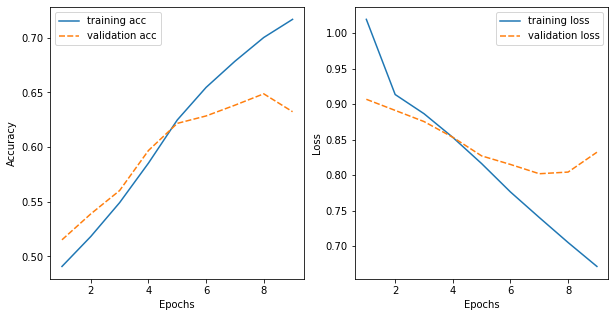

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.087, train_acc:0.391, val Loss: : 1.102128, val_acc: 0.376
[epoch 2] train_loss: 0.993, train_acc:0.503, val Loss: : 0.961998, val_acc: 0.476
[epoch 3] train_loss: 0.868, train_acc:0.593, val Loss: : 0.978269, val_acc: 0.503
[epoch 4] train_loss: 0.747, train_acc:0.659, val Loss: : 0.923421, val_acc: 0.555
[epoch 5] train_loss: 0.636, train_acc:0.720, val Loss: : 0.905222, val_acc: 0.589
[epoch 6] train_loss: 0.540, train_acc:0.766, val Loss: : 0.947125, val_acc: 0.599
[epoch 7] train_loss: 0.470, train_acc:0.797, val Loss: : 0.957408, val_acc: 0.613
[epoch 8] train_loss: 0.415, train_acc:0.819, val Loss: : 0.994749, val_acc: 0.623


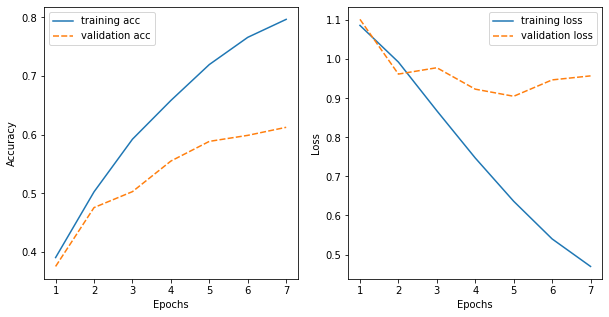

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.085, train_acc:0.391, val Loss: : 1.112393, val_acc: 0.348
[epoch 2] train_loss: 0.988, train_acc:0.504, val Loss: : 1.153306, val_acc: 0.373
[epoch 3] train_loss: 0.878, train_acc:0.584, val Loss: : 1.008408, val_acc: 0.486
[epoch 4] train_loss: 0.771, train_acc:0.650, val Loss: : 0.890920, val_acc: 0.569
[epoch 5] train_loss: 0.678, train_acc:0.697, val Loss: : 0.910335, val_acc: 0.578
[epoch 6] train_loss: 0.601, train_acc:0.735, val Loss: : 0.913887, val_acc: 0.596
[epoch 7] train_loss: 0.519, train_acc:0.777, val Loss: : 0.953798, val_acc: 0.624


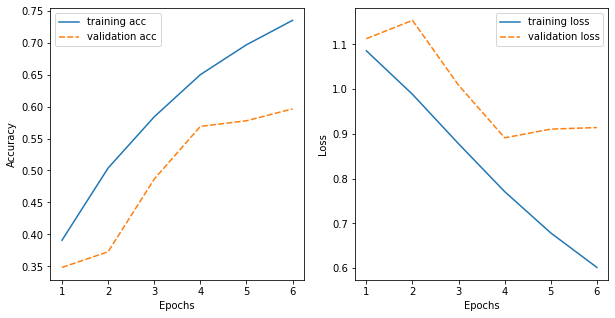

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.082, train_acc:0.397, val Loss: : 1.134165, val_acc: 0.329
[epoch 2] train_loss: 0.971, train_acc:0.505, val Loss: : 0.993700, val_acc: 0.443
[epoch 3] train_loss: 0.851, train_acc:0.588, val Loss: : 1.102055, val_acc: 0.444
[epoch 4] train_loss: 0.747, train_acc:0.653, val Loss: : 0.935880, val_acc: 0.548
[epoch 5] train_loss: 0.644, train_acc:0.708, val Loss: : 0.939197, val_acc: 0.576
[epoch 6] train_loss: 0.565, train_acc:0.748, val Loss: : 0.921838, val_acc: 0.603
[epoch 7] train_loss: 0.506, train_acc:0.776, val Loss: : 0.969900, val_acc: 0.603
[epoch 8] train_loss: 0.460, train_acc:0.799, val Loss: : 0.996446, val_acc: 0.614
[epoch 9] train_loss: 0.409, train_acc:0.824, val Loss: : 0.984766, val_a

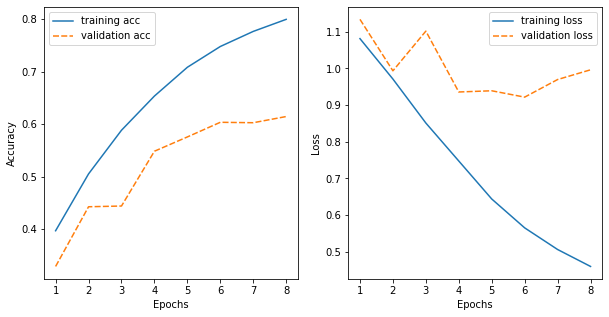

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_del
----------------------------------------------------------------------
[epoch 1] train_loss: 1.080, train_acc:0.400, val Loss: : 1.156733, val_acc: 0.283
[epoch 2] train_loss: 0.955, train_acc:0.532, val Loss: : 1.096154, val_acc: 0.432
[epoch 3] train_loss: 0.817, train_acc:0.616, val Loss: : 1.022326, val_acc: 0.503
[epoch 4] train_loss: 0.714, train_acc:0.674, val Loss: : 0.894207, val_acc: 0.580
[epoch 5] train_loss: 0.643, train_acc:0.715, val Loss: : 0.882423, val_acc: 0.603
[epoch 6] train_loss: 0.575, train_acc:0.745, val Loss: : 1.018417, val_acc: 0.568
[epoch 7] train_loss: 0.517, train_acc:0.773, val Loss: : 0.887639, val_acc: 0.624
[epoch 8] train_loss: 0.457, train_acc:0.802, val Loss: : 0.951430, val_acc: 0.611


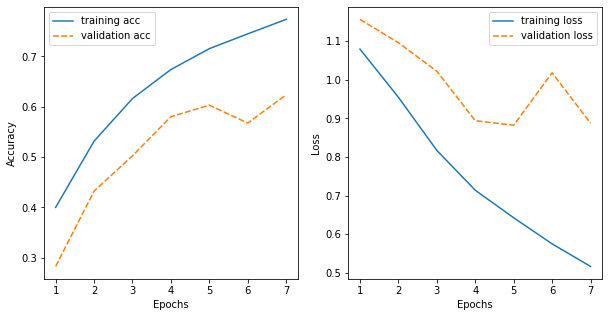

----------------------------------------------------------------------
acc_list [0.6315906315906316, 0.622932622932623, 0.622932622932623, 0.613941613941614, 0.5982905982905983]
loss_list [0.8518379926681519, 0.9713499546051025, 0.9119479656219482, 0.9691357612609863, 0.9604386687278748]
precision_list [array([0.18108974, 0.63271778, 0.72255291]), array([0.26821192, 0.62545524, 0.72972973]), array([0.27039627, 0.65246126, 0.66888121]), array([0.25653798, 0.64750344, 0.65052083]), array([0.20431894, 0.64341801, 0.67856115])]
recall_list [array([0.16544656, 0.76293297, 0.56314433]), array([0.35578331, 0.73391813, 0.54278351]), array([0.33967789, 0.64394962, 0.64871134]), array([0.30161054, 0.63585245, 0.64381443]), array([0.3601757 , 0.62663068, 0.60773196])]
fscore_list [array([0.17291507, 0.69175079, 0.6329664 ]), array([0.30585274, 0.67535962, 0.62252439]), array([0.30110318, 0.6481775 , 0.65864189]), array([0.27725437, 0.64162506, 0.64715026]), array([0.26073132, 0.6349134 , 0.641196

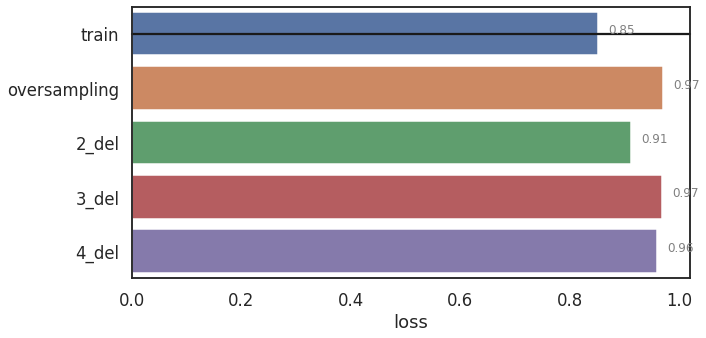

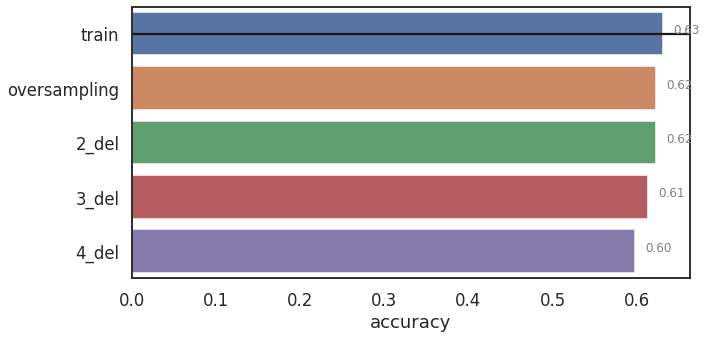

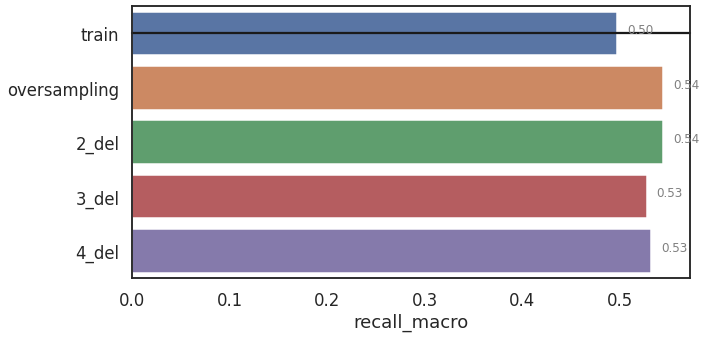

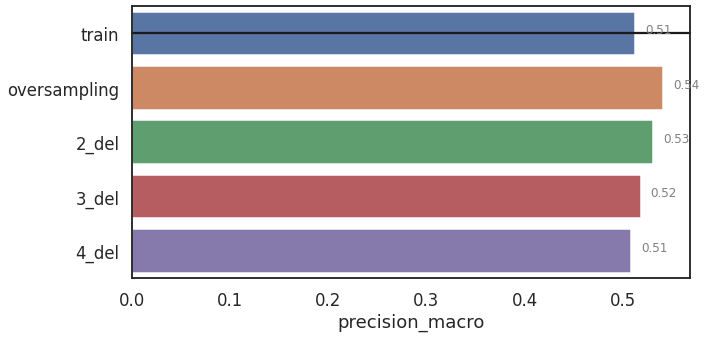

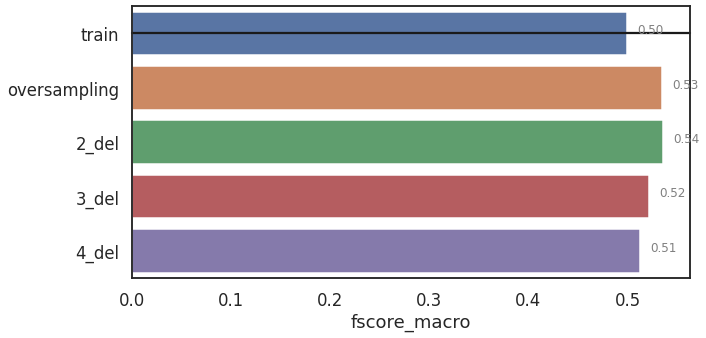

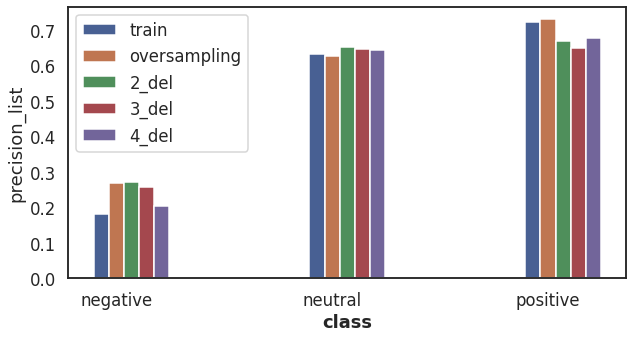

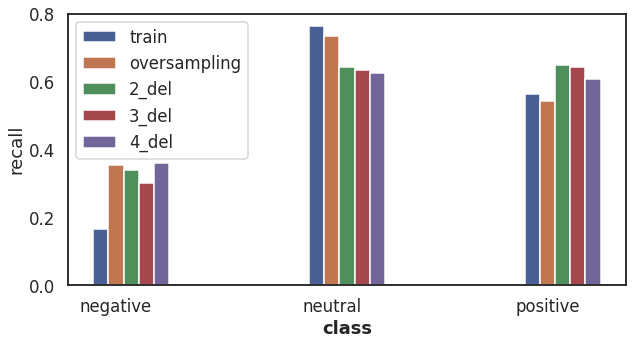

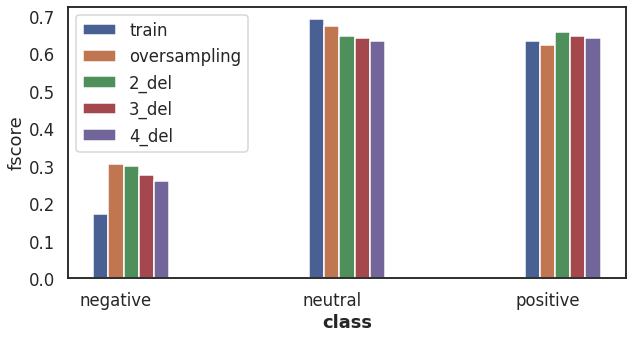

In [9]:

task_name = 'sub_twitter'
tech_name = 'EDA'
test_list = [
            'train',
            'oversampling',
            '2_del',
            '3_del',
            '4_del',
            # '5_del',
            ]

Execute(test_list, task_name, tech_name)

## *Fasttext_augmentation*

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.015, train_acc:0.482, val Loss: : 0.905947, val_acc: 0.507
[epoch 2] train_loss: 0.913, train_acc:0.513, val Loss: : 0.891301, val_acc: 0.529
[epoch 3] train_loss: 0.886, train_acc:0.550, val Loss: : 0.875578, val_acc: 0.561
[epoch 4] train_loss: 0.854, train_acc:0.585, val Loss: : 0.862249, val_acc: 0.593
[epoch 5] train_loss: 0.813, train_acc:0.627, val Loss: : 0.839735, val_acc: 0.617
[epoch 6] train_loss: 0.771, train_acc:0.655, val Loss: : 0.814140, val_acc: 0.626
[epoch 7] train_loss: 0.742, train_acc:0.678, val Loss: : 0.806068, val_acc: 0.633
[epoch 8] train_loss: 0.704, train_acc:0.699, val Loss: : 0.840127, val_acc: 0.621
[epoch 9] train_loss: 0.664, train_acc:0.718, val Loss: : 0.812051, val_acc: 0.635
[epoch 10] train_loss: 0.628, train_acc:0.740, val Loss: : 0.

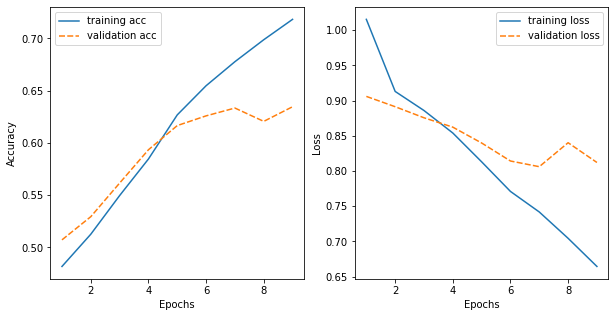

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.084, train_acc:0.399, val Loss: : 1.097844, val_acc: 0.381
[epoch 2] train_loss: 0.985, train_acc:0.507, val Loss: : 1.027453, val_acc: 0.445
[epoch 3] train_loss: 0.860, train_acc:0.600, val Loss: : 0.945743, val_acc: 0.535
[epoch 4] train_loss: 0.730, train_acc:0.673, val Loss: : 0.905837, val_acc: 0.571
[epoch 5] train_loss: 0.614, train_acc:0.734, val Loss: : 0.881793, val_acc: 0.604
[epoch 6] train_loss: 0.521, train_acc:0.776, val Loss: : 0.929841, val_acc: 0.610
[epoch 7] train_loss: 0.445, train_acc:0.807, val Loss: : 0.921840, val_acc: 0.643
[epoch 8] train_loss: 0.402, train_acc:0.827, val Loss: : 1.032473, val_acc: 0.615


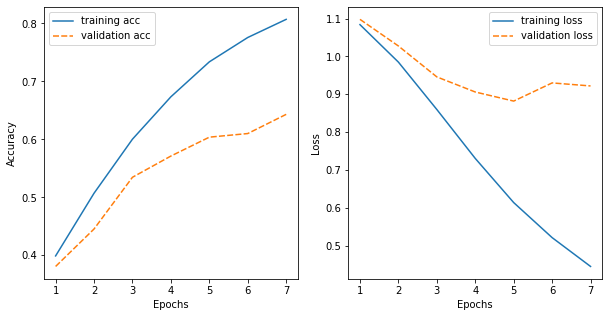

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep
----------------------------------------------------------------------
[epoch 1] train_loss: 1.083, train_acc:0.398, val Loss: : 1.042143, val_acc: 0.410
[epoch 2] train_loss: 0.953, train_acc:0.515, val Loss: : 0.938072, val_acc: 0.459
[epoch 3] train_loss: 0.811, train_acc:0.609, val Loss: : 0.930469, val_acc: 0.518
[epoch 4] train_loss: 0.711, train_acc:0.661, val Loss: : 1.003684, val_acc: 0.534
[epoch 5] train_loss: 0.624, train_acc:0.703, val Loss: : 0.923939, val_acc: 0.575
[epoch 6] train_loss: 0.559, train_acc:0.745, val Loss: : 0.843872, val_acc: 0.623
[epoch 7] train_loss: 0.507, train_acc:0.763, val Loss: : 0.884151, val_acc: 0.622
[epoch 8] train_loss: 0.459, train_acc:0.791, val Loss: : 0.866789, val_acc: 0.642
[epoch 9] train_loss: 0.412, train_acc:0.813, val Loss: : 0.925191, val_a

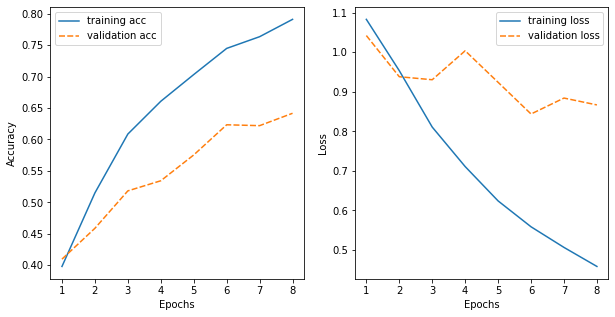

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep
----------------------------------------------------------------------
[epoch 1] train_loss: 1.080, train_acc:0.408, val Loss: : 1.052419, val_acc: 0.413
[epoch 2] train_loss: 0.915, train_acc:0.549, val Loss: : 0.946617, val_acc: 0.502
[epoch 3] train_loss: 0.748, train_acc:0.639, val Loss: : 0.915018, val_acc: 0.563
[epoch 4] train_loss: 0.640, train_acc:0.698, val Loss: : 0.882124, val_acc: 0.598
[epoch 5] train_loss: 0.577, train_acc:0.730, val Loss: : 0.860017, val_acc: 0.616
[epoch 6] train_loss: 0.516, train_acc:0.764, val Loss: : 0.845706, val_acc: 0.623
[epoch 7] train_loss: 0.469, train_acc:0.787, val Loss: : 0.863833, val_acc: 0.637
[epoch 8] train_loss: 0.426, train_acc:0.811, val Loss: : 0.891871, val_acc: 0.628
[epoch 9] train_loss: 0.389, train_acc:0.830, val Loss: : 0.913708, val_a

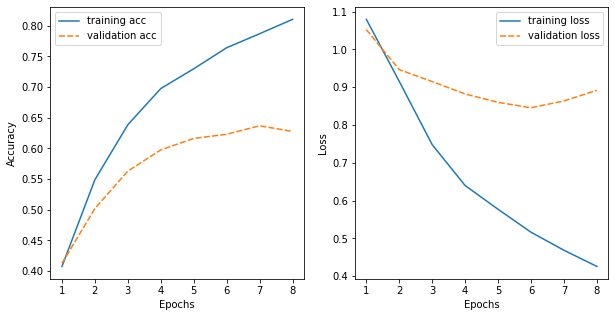

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep
----------------------------------------------------------------------
[epoch 1] train_loss: 1.071, train_acc:0.422, val Loss: : 1.073679, val_acc: 0.391
[epoch 2] train_loss: 0.882, train_acc:0.546, val Loss: : 0.920664, val_acc: 0.458
[epoch 3] train_loss: 0.750, train_acc:0.612, val Loss: : 0.920138, val_acc: 0.513
[epoch 4] train_loss: 0.666, train_acc:0.668, val Loss: : 0.877590, val_acc: 0.561
[epoch 5] train_loss: 0.600, train_acc:0.710, val Loss: : 0.867642, val_acc: 0.589
[epoch 6] train_loss: 0.546, train_acc:0.742, val Loss: : 0.867839, val_acc: 0.606
[epoch 7] train_loss: 0.503, train_acc:0.769, val Loss: : 0.896893, val_acc: 0.611
[epoch 8] train_loss: 0.466, train_acc:0.791, val Loss: : 0.871282, val_acc: 0.633


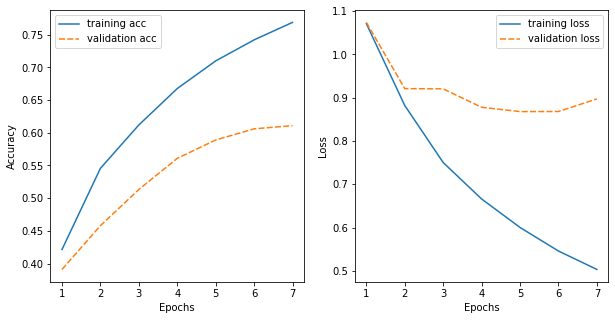

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep
----------------------------------------------------------------------
[epoch 1] train_loss: 1.057, train_acc:0.441, val Loss: : 0.958595, val_acc: 0.475
[epoch 2] train_loss: 0.867, train_acc:0.568, val Loss: : 0.906588, val_acc: 0.541
[epoch 3] train_loss: 0.740, train_acc:0.640, val Loss: : 0.850806, val_acc: 0.596
[epoch 4] train_loss: 0.649, train_acc:0.691, val Loss: : 0.817843, val_acc: 0.610
[epoch 5] train_loss: 0.586, train_acc:0.728, val Loss: : 0.848403, val_acc: 0.614
[epoch 6] train_loss: 0.533, train_acc:0.756, val Loss: : 0.820697, val_acc: 0.637
[epoch 7] train_loss: 0.486, train_acc:0.783, val Loss: : 0.814422, val_acc: 0.643
[epoch 8] train_loss: 0.447, train_acc:0.803, val Loss: : 0.854384, val_acc: 0.633
[epoch 9] train_loss: 0.409, train_acc:0.824, val Loss: : 0.879643, val_a

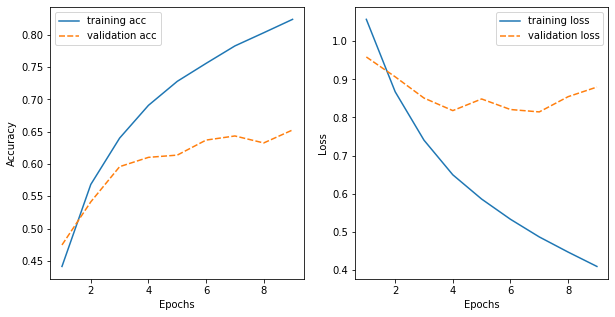

----------------------------------------------------------------------
acc_list [0.6472416472416472, 0.6055056055056055, 0.6189366189366189, 0.6271506271506272, 0.6410256410256411, 0.6449106449106449]
loss_list [0.8173302412033081, 1.0420559644699097, 0.9221992492675781, 0.9235547184944153, 0.8538991212844849, 0.8594377040863037]
precision_list [array([0.27002967, 0.63222543, 0.71428571]), array([0.26461295, 0.67219695, 0.65102346]), array([0.24660633, 0.64144028, 0.68339547]), array([0.24700762, 0.63550296, 0.72880795]), array([0.328125  , 0.64226825, 0.67223439]), array([0.3255814 , 0.6430732 , 0.69411432])]
recall_list [array([0.13323572, 0.78722447, 0.57731959]), array([0.49048316, 0.56500225, 0.67216495]), array([0.31918009, 0.6691408 , 0.61417526]), array([0.33235725, 0.72469636, 0.56726804]), array([0.18448023, 0.71839856, 0.63273196]), array([0.24597365, 0.71727395, 0.63221649])]
fscore_list [array([0.17843137, 0.70126227, 0.63854048]), array([0.34376603, 0.61395576, 0.66142531

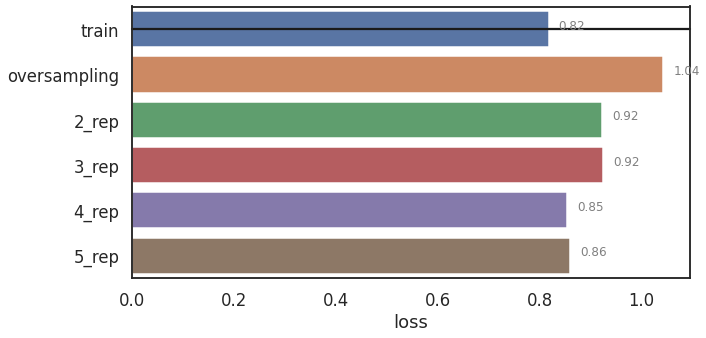

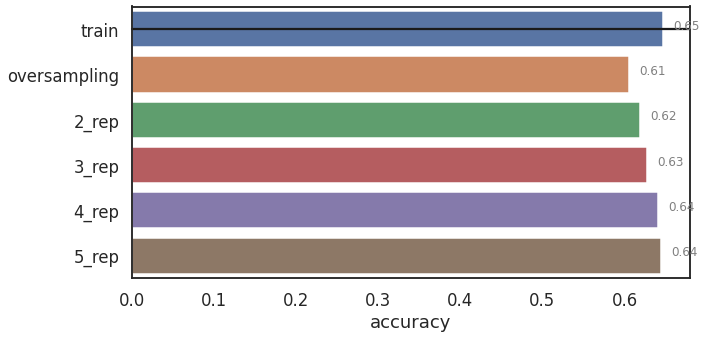

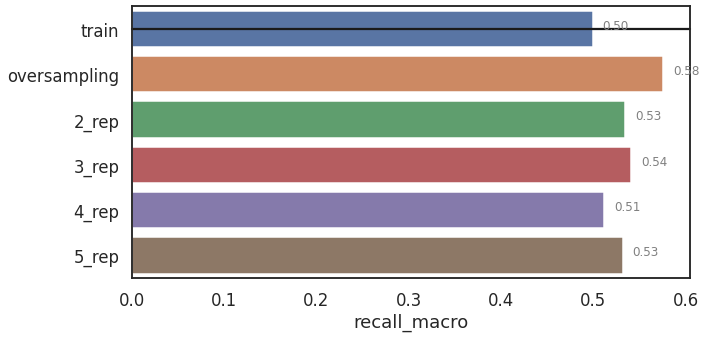

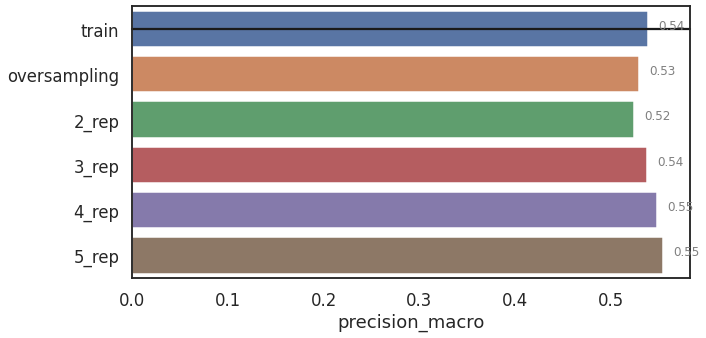

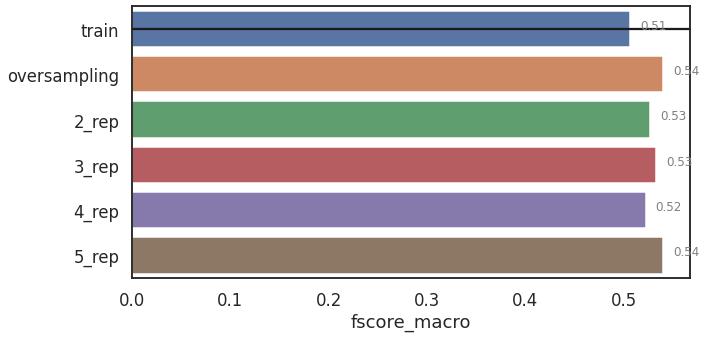

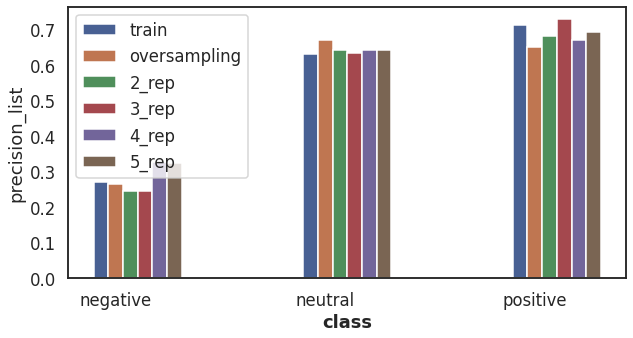

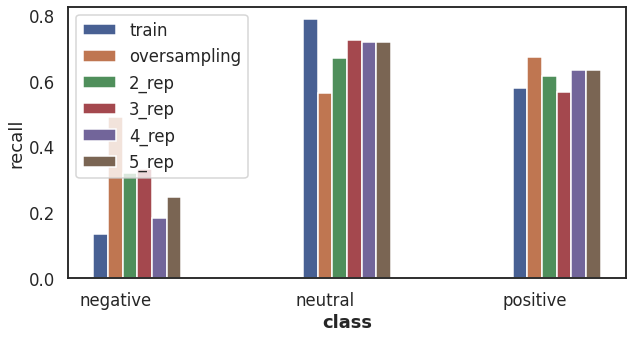

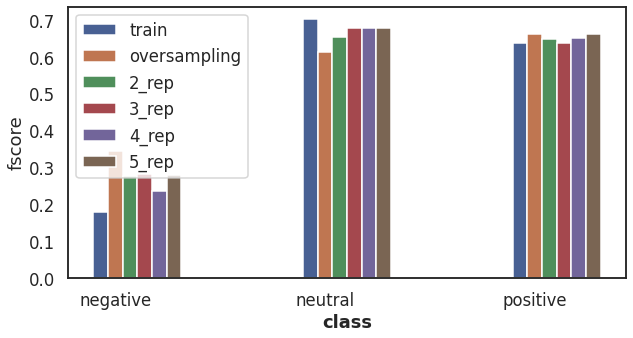

In [9]:

task_name = 'sub_twitter'
tech_name = 'Fasttext_augmentation'
test_list = [
            'train',
            'oversampling',
            '2_rep',
            '3_rep',
            '4_rep',
            '5_rep'
            ]

Execute(test_list, task_name, tech_name)

## *Back_translation*

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.021, train_acc:0.468, val Loss: : 0.901759, val_acc: 0.515
[epoch 2] train_loss: 0.914, train_acc:0.512, val Loss: : 0.890019, val_acc: 0.531
[epoch 3] train_loss: 0.887, train_acc:0.548, val Loss: : 0.872556, val_acc: 0.565
[epoch 4] train_loss: 0.849, train_acc:0.591, val Loss: : 0.851983, val_acc: 0.594
[epoch 5] train_loss: 0.807, train_acc:0.632, val Loss: : 0.825543, val_acc: 0.622
[epoch 6] train_loss: 0.772, train_acc:0.657, val Loss: : 0.813235, val_acc: 0.626
[epoch 7] train_loss: 0.740, train_acc:0.679, val Loss: : 0.796313, val_acc: 0.646
[epoch 8] train_loss: 0.706, train_acc:0.698, val Loss: : 0.819314, val_acc: 0.644
[epoch 9] train_loss: 0.675, train_acc:0.714, val Loss: : 0.816336, val_acc: 0.644
[epoch 10] train_loss: 0.638, train_acc:0.738, val Loss: : 0.

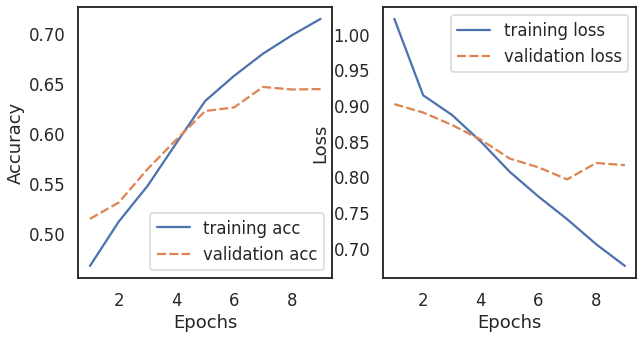

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.087, train_acc:0.394, val Loss: : 1.076994, val_acc: 0.405
[epoch 2] train_loss: 0.993, train_acc:0.504, val Loss: : 1.093790, val_acc: 0.394
[epoch 3] train_loss: 0.860, train_acc:0.598, val Loss: : 0.974109, val_acc: 0.515
[epoch 4] train_loss: 0.737, train_acc:0.668, val Loss: : 0.877255, val_acc: 0.590
[epoch 5] train_loss: 0.629, train_acc:0.724, val Loss: : 0.936615, val_acc: 0.583
[epoch 6] train_loss: 0.540, train_acc:0.768, val Loss: : 0.977636, val_acc: 0.588
[epoch 7] train_loss: 0.480, train_acc:0.794, val Loss: : 1.003232, val_acc: 0.605


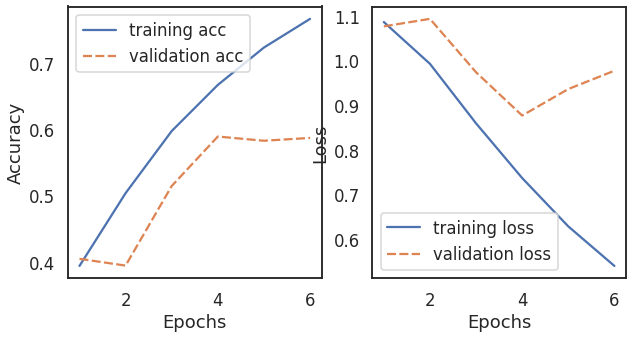

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : negative_aug
----------------------------------------------------------------------
[epoch 1] train_loss: 1.069, train_acc:0.399, val Loss: : 1.035949, val_acc: 0.446
[epoch 2] train_loss: 0.933, train_acc:0.520, val Loss: : 0.929914, val_acc: 0.478
[epoch 3] train_loss: 0.811, train_acc:0.601, val Loss: : 0.860644, val_acc: 0.571
[epoch 4] train_loss: 0.720, train_acc:0.657, val Loss: : 0.841876, val_acc: 0.598
[epoch 5] train_loss: 0.641, train_acc:0.701, val Loss: : 0.891467, val_acc: 0.579
[epoch 6] train_loss: 0.576, train_acc:0.736, val Loss: : 0.832807, val_acc: 0.621
[epoch 7] train_loss: 0.517, train_acc:0.769, val Loss: : 0.884181, val_acc: 0.625
[epoch 8] train_loss: 0.460, train_acc:0.796, val Loss: : 0.942317, val_acc: 0.618
[epoch 9] train_loss: 0.411, train_acc:0.820, val Loss: : 0.920220

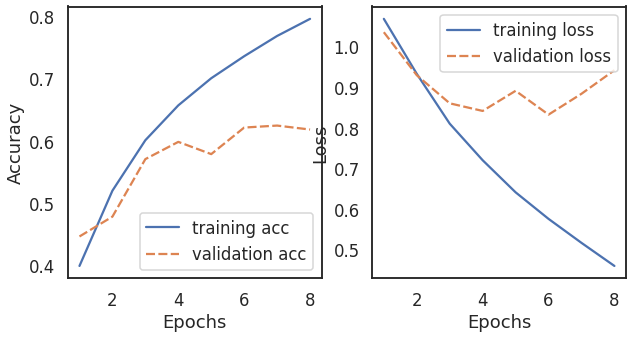

----------------------------------------------------------------------
acc_list [0.6358086358086358, 0.5860805860805861, 0.6224886224886225]
loss_list [0.8661512136459351, 1.0374627113342285, 0.9058142304420471]
precision_list [array([0.24752475, 0.60465869, 0.73904762]), array([0.20856821, 0.65721519, 0.704414  ]), array([0.28289474, 0.65041398, 0.65752371])]
recall_list [array([0.07320644, 0.84075574, 0.5       ]), array([0.54172767, 0.58389564, 0.59639175]), array([0.3147877 , 0.63607737, 0.66108247])]
fscore_list [array([0.11299435, 0.70342492, 0.59646426]), array([0.3011803 , 0.61838971, 0.64591766]), array([0.2979903 , 0.64316579, 0.65929829])]
average recall [0.47132072588649615, 0.5740050203798913, 0.5373158494879994]
average fs [0.4709611746211295, 0.5218292219447966, 0.5334847945195217]
average precision [0.5304103526773623, 0.5233991334527898, 0.5302774773838398]


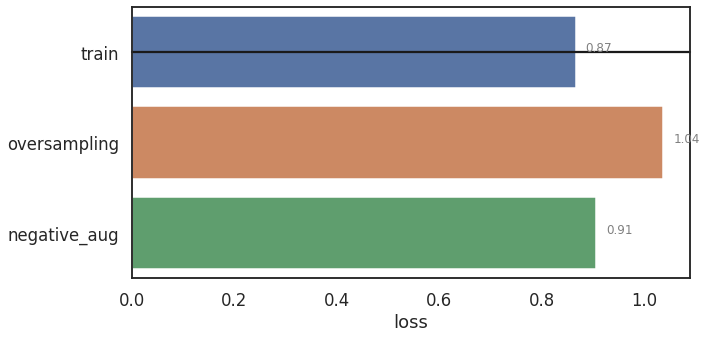

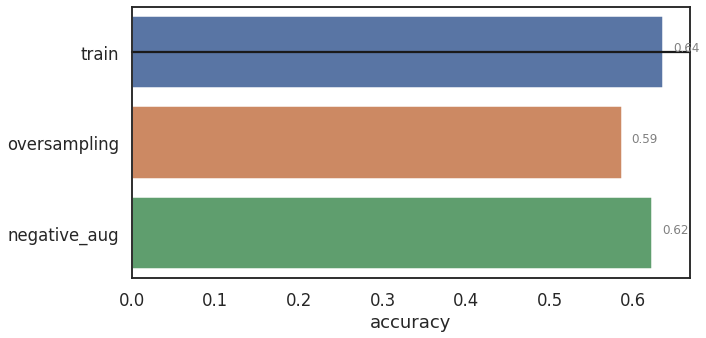

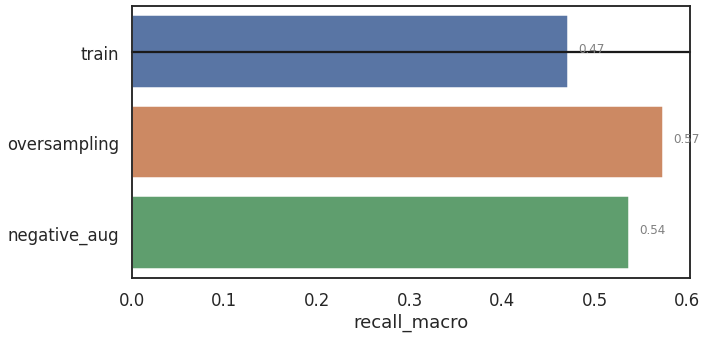

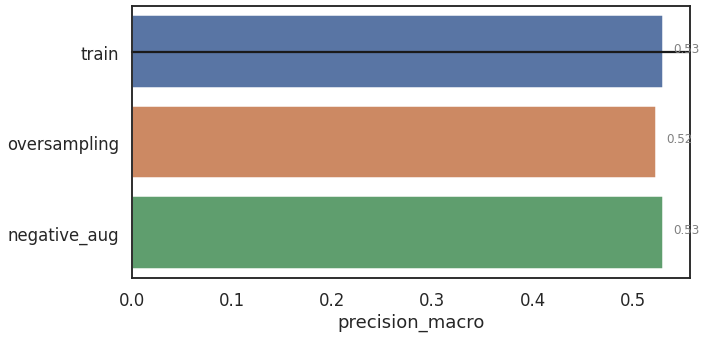

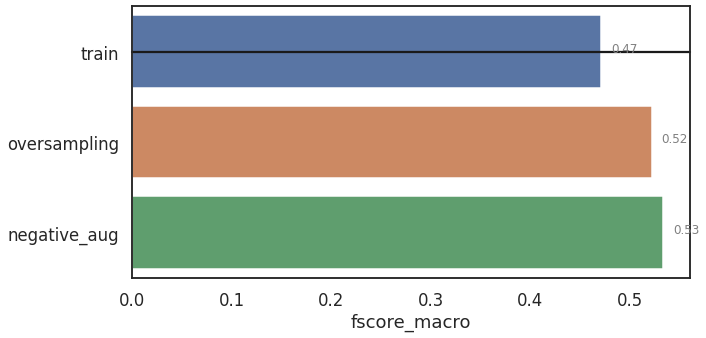

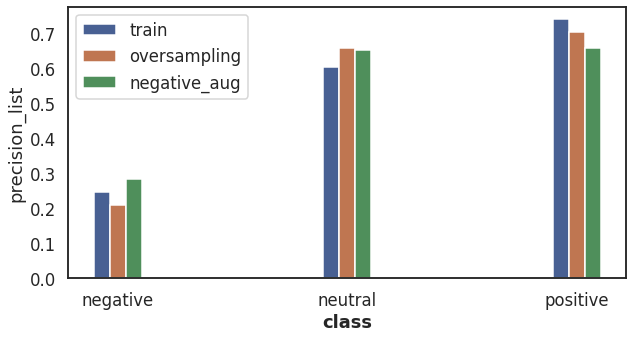

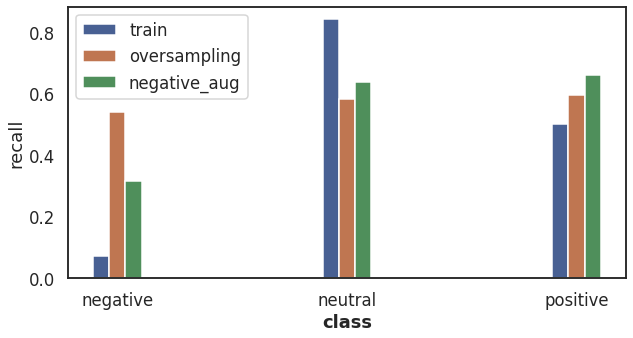

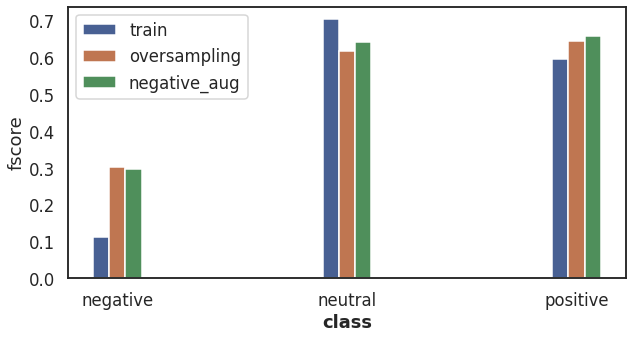

In [10]:

task_name = 'sub_twitter'
tech_name = 'Back_trans'
test_list = [
            'train',
            'oversampling',
            'negative_aug'
            ]

Execute(test_list, task_name, tech_name)


## *Pretrain BERT test dataset*


----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.031, train_acc:0.472, val Loss: : 0.903268, val_acc: 0.503
[epoch 2] train_loss: 0.913, train_acc:0.512, val Loss: : 0.893166, val_acc: 0.532
[epoch 3] train_loss: 0.887, train_acc:0.550, val Loss: : 0.879211, val_acc: 0.553
[epoch 4] train_loss: 0.858, train_acc:0.581, val Loss: : 0.857884, val_acc: 0.590
[epoch 5] train_loss: 0.818, train_acc:0.619, val Loss: : 0.842159, val_acc: 0.605
[epoch 6] train_loss: 0.784, train_acc:0.647, val Loss: : 0.818687, val_acc: 0.623
[epoch 7] train_loss: 0.749, train_acc:0.670, val Loss: : 0.832001, val_acc: 0.615
[epoch 8] train_loss: 0.713, train_acc:0.689, val Loss: : 0.823102, val_acc: 0.638
[epoch 9] train_loss: 0.676, train_acc:0.713, val Loss: : 0.840945, val_acc: 0.624


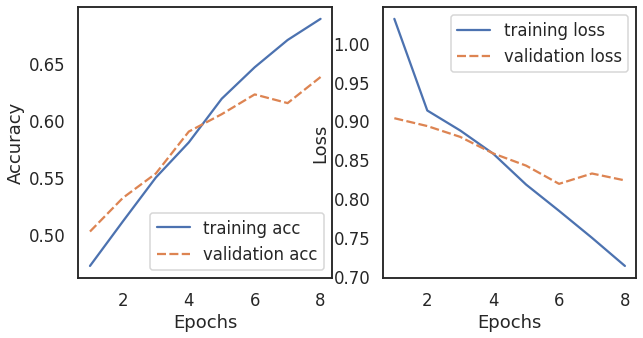

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.085, train_acc:0.392, val Loss: : 1.095280, val_acc: 0.378
[epoch 2] train_loss: 0.988, train_acc:0.505, val Loss: : 0.944246, val_acc: 0.491
[epoch 3] train_loss: 0.858, train_acc:0.599, val Loss: : 0.912977, val_acc: 0.553
[epoch 4] train_loss: 0.731, train_acc:0.674, val Loss: : 0.865448, val_acc: 0.586
[epoch 5] train_loss: 0.629, train_acc:0.726, val Loss: : 0.872692, val_acc: 0.617
[epoch 6] train_loss: 0.547, train_acc:0.766, val Loss: : 0.923061, val_acc: 0.599
[epoch 7] train_loss: 0.483, train_acc:0.790, val Loss: : 1.021503, val_acc: 0.605


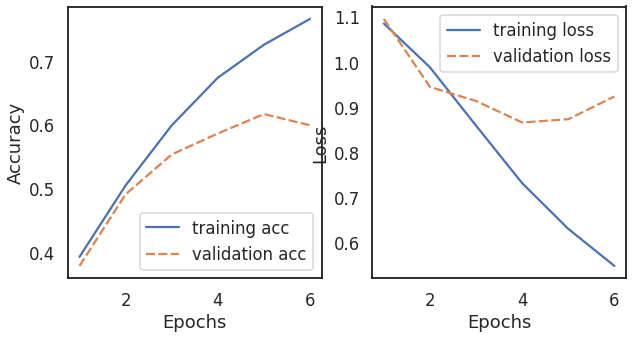

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.077, train_acc:0.400, val Loss: : 1.097895, val_acc: 0.377
[epoch 2] train_loss: 0.958, train_acc:0.517, val Loss: : 1.062021, val_acc: 0.415
[epoch 3] train_loss: 0.840, train_acc:0.594, val Loss: : 1.013965, val_acc: 0.497
[epoch 4] train_loss: 0.728, train_acc:0.662, val Loss: : 0.902824, val_acc: 0.567
[epoch 5] train_loss: 0.634, train_acc:0.711, val Loss: : 0.906811, val_acc: 0.589
[epoch 6] train_loss: 0.567, train_acc:0.743, val Loss: : 0.955000, val_acc: 0.586
[epoch 7] train_loss: 0.504, train_acc:0.774, val Loss: : 0.870685, val_acc: 0.637
[epoch 8] train_loss: 0.447, train_acc:0.802, val Loss: : 0.945307, val_acc: 0.624
[epoch 9] train_loss: 0.405, train_acc:0.821, val Loss: : 0.9533

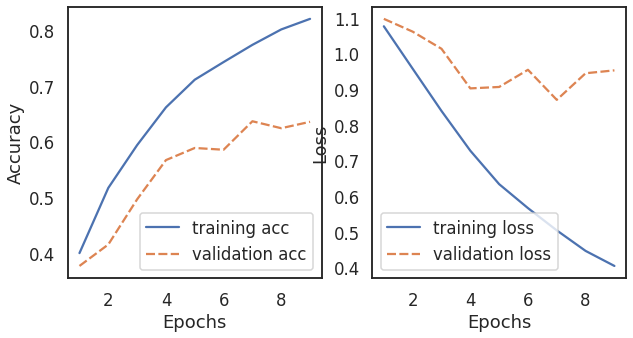

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.069, train_acc:0.412, val Loss: : 1.072635, val_acc: 0.399
[epoch 2] train_loss: 0.926, train_acc:0.535, val Loss: : 0.939241, val_acc: 0.502
[epoch 3] train_loss: 0.802, train_acc:0.616, val Loss: : 0.883232, val_acc: 0.564
[epoch 4] train_loss: 0.698, train_acc:0.672, val Loss: : 0.938117, val_acc: 0.561
[epoch 5] train_loss: 0.622, train_acc:0.716, val Loss: : 0.946111, val_acc: 0.581
[epoch 6] train_loss: 0.550, train_acc:0.752, val Loss: : 0.909874, val_acc: 0.610


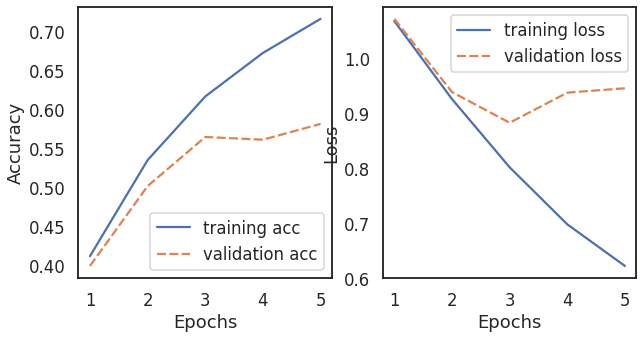

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.059, train_acc:0.425, val Loss: : 1.065279, val_acc: 0.398
[epoch 2] train_loss: 0.885, train_acc:0.545, val Loss: : 0.946189, val_acc: 0.483
[epoch 3] train_loss: 0.765, train_acc:0.617, val Loss: : 0.916551, val_acc: 0.526
[epoch 4] train_loss: 0.677, train_acc:0.666, val Loss: : 0.896486, val_acc: 0.563
[epoch 5] train_loss: 0.609, train_acc:0.708, val Loss: : 0.911605, val_acc: 0.580
[epoch 6] train_loss: 0.550, train_acc:0.744, val Loss: : 0.898060, val_acc: 0.611
[epoch 7] train_loss: 0.502, train_acc:0.771, val Loss: : 0.844222, val_acc: 0.633
[epoch 8] train_loss: 0.461, train_acc:0.791, val Loss: : 0.880154, val_acc: 0.621
[epoch 9] train_loss: 0.410, train_acc:0.818, val Loss: : 0.9143

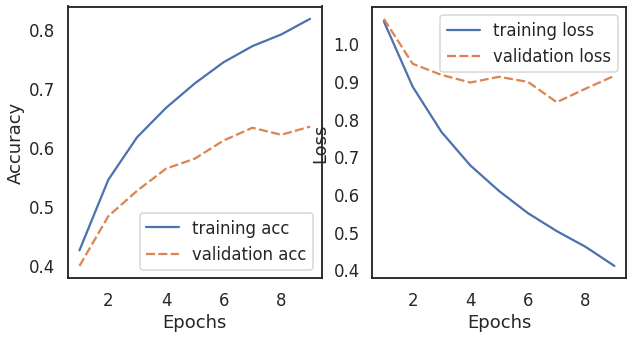

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(unfine)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.050, train_acc:0.436, val Loss: : 1.062536, val_acc: 0.414
[epoch 2] train_loss: 0.848, train_acc:0.567, val Loss: : 0.926541, val_acc: 0.505
[epoch 3] train_loss: 0.734, train_acc:0.632, val Loss: : 0.949147, val_acc: 0.521
[epoch 4] train_loss: 0.663, train_acc:0.679, val Loss: : 0.914798, val_acc: 0.552
[epoch 5] train_loss: 0.608, train_acc:0.707, val Loss: : 0.843383, val_acc: 0.598
[epoch 6] train_loss: 0.554, train_acc:0.743, val Loss: : 0.852949, val_acc: 0.619
[epoch 7] train_loss: 0.504, train_acc:0.772, val Loss: : 0.855950, val_acc: 0.625
[epoch 8] train_loss: 0.461, train_acc:0.795, val Loss: : 0.861593, val_acc: 0.631


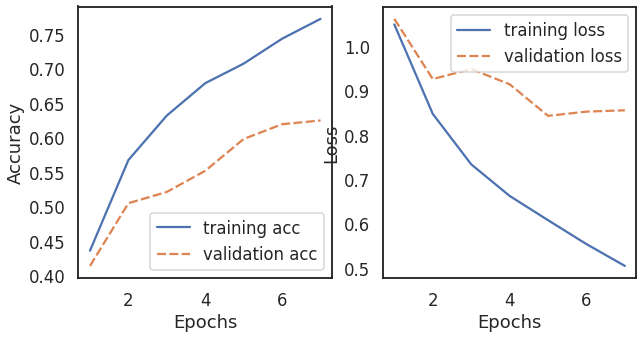

----------------------------------------------------------------------
acc_list [0.6366966366966367, 0.594960594960595, 0.6219336219336219, 0.6193806193806194, 0.6392496392496393, 0.6298146298146298]
loss_list [0.810442328453064, 1.011069893836975, 0.9534329771995544, 0.885149359703064, 0.8734834790229797, 0.8494188189506531]
precision_list [array([0.26712329, 0.65843621, 0.62753397]), array([0.24257426, 0.67678214, 0.64675768]), array([0.26863085, 0.65200368, 0.6398533 ]), array([0.24610895, 0.6306411 , 0.73491838]), array([0.34223301, 0.66406787, 0.64258735]), array([0.27474403, 0.64963178, 0.66007103])]
recall_list [array([0.05710102, 0.64777328, 0.72603093]), array([0.50219619, 0.5317139 , 0.68376289]), array([0.22693997, 0.63675214, 0.67448454]), array([0.3704246 , 0.73234368, 0.53376289]), array([0.20644217, 0.65137202, 0.70154639]), array([0.23572474, 0.65474584, 0.67061856])]
fscore_list [array([0.09408926, 0.65306122, 0.67319871]), array([0.327134  , 0.595541  , 0.66474568]), 

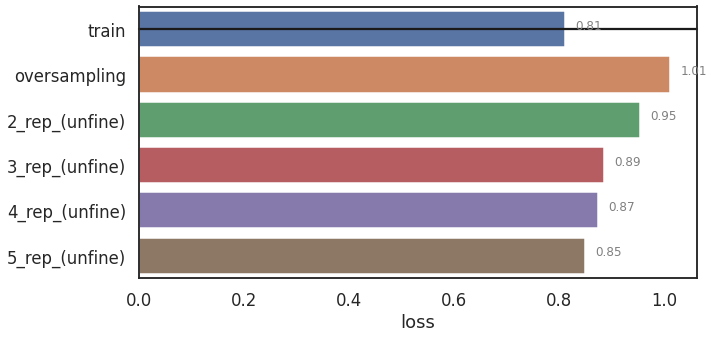

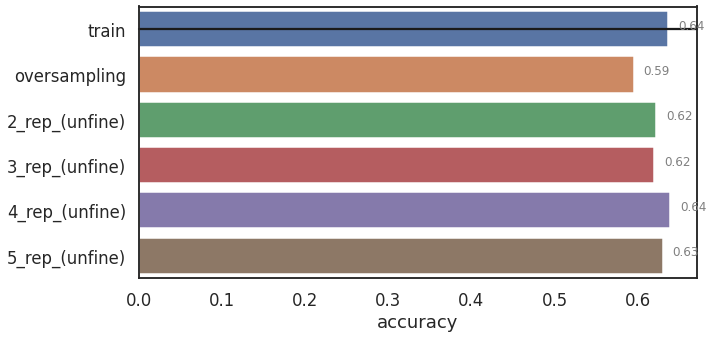

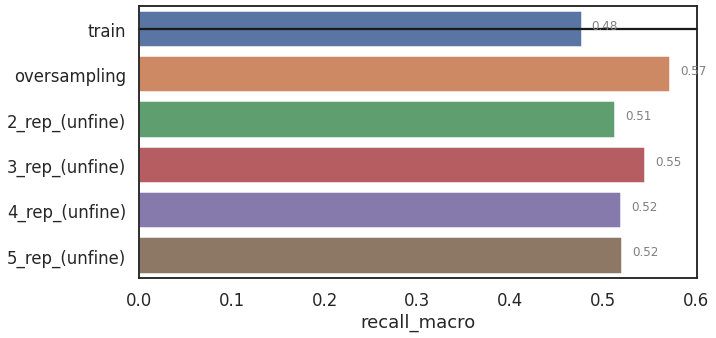

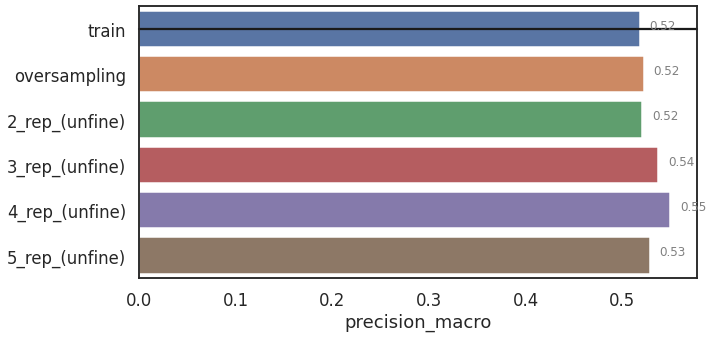

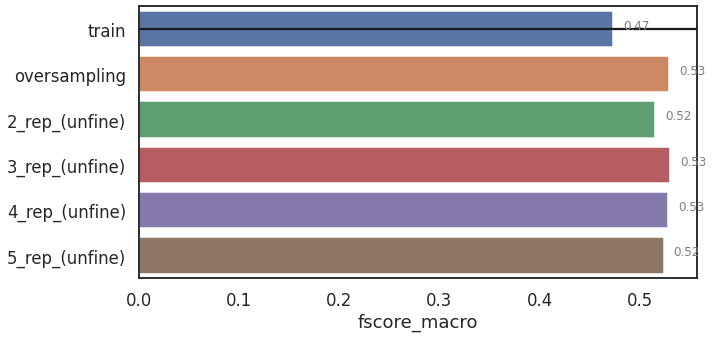

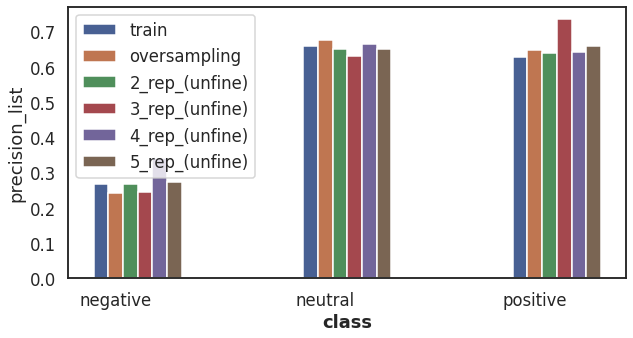

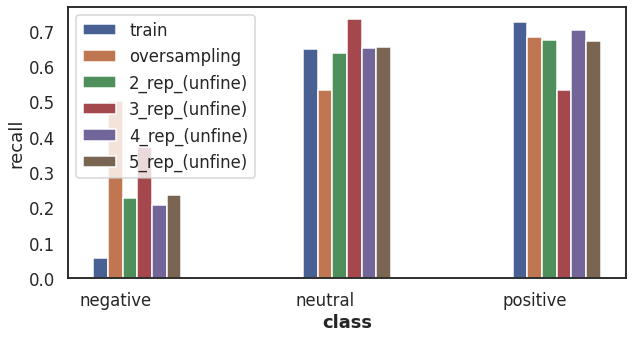

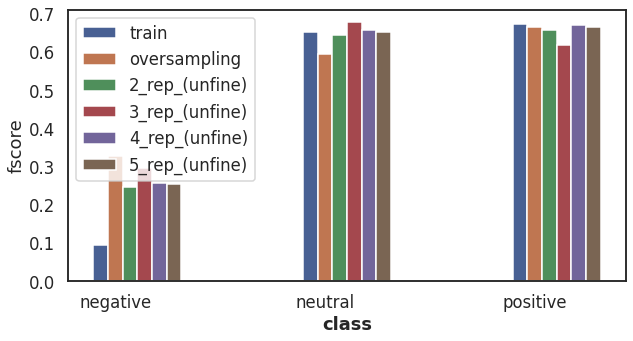

In [12]:

## Pretrain BERT CLS

task_name = 'sub_twitter'
tech_name = 'Bert_ data augmentation-master'
test_list = [
      'train',
      'oversampling',
      '2_rep_(unfine)',
      '3_rep_(unfine)',
      '4_rep_(unfine)',
      '5_rep_(unfine)',
      
      ]

Execute(test_list, task_name, tech_name)

## *fine tuned data aug*,test data 

----------------------------------------------------------------------
Start to make classification use the data : train
----------------------------------------------------------------------
[epoch 1] train_loss: 1.023, train_acc:0.489, val Loss: : 0.901514, val_acc: 0.502
[epoch 2] train_loss: 0.915, train_acc:0.517, val Loss: : 0.890776, val_acc: 0.535
[epoch 3] train_loss: 0.888, train_acc:0.544, val Loss: : 0.878642, val_acc: 0.554
[epoch 4] train_loss: 0.856, train_acc:0.584, val Loss: : 0.854229, val_acc: 0.590
[epoch 5] train_loss: 0.819, train_acc:0.626, val Loss: : 0.855876, val_acc: 0.606
[epoch 6] train_loss: 0.779, train_acc:0.656, val Loss: : 0.821865, val_acc: 0.631
[epoch 7] train_loss: 0.744, train_acc:0.678, val Loss: : 0.835007, val_acc: 0.625
[epoch 8] train_loss: 0.706, train_acc:0.699, val Loss: : 0.810127, val_acc: 0.648
[epoch 9] train_loss: 0.672, train_acc:0.718, val Loss: : 0.819075, val_acc: 0.647
[epoch 10] train_loss: 0.631, train_acc:0.742, val Loss: : 0.

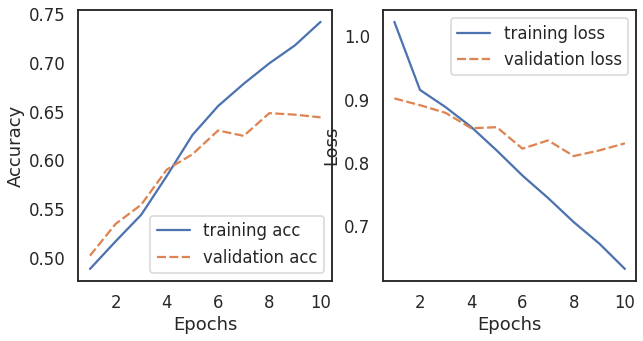

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : oversampling
----------------------------------------------------------------------
[epoch 1] train_loss: 1.082, train_acc:0.402, val Loss: : 1.069349, val_acc: 0.412
[epoch 2] train_loss: 0.978, train_acc:0.512, val Loss: : 1.018659, val_acc: 0.455
[epoch 3] train_loss: 0.853, train_acc:0.601, val Loss: : 0.914081, val_acc: 0.551
[epoch 4] train_loss: 0.728, train_acc:0.675, val Loss: : 0.896886, val_acc: 0.575
[epoch 5] train_loss: 0.621, train_acc:0.731, val Loss: : 0.939411, val_acc: 0.586
[epoch 6] train_loss: 0.534, train_acc:0.767, val Loss: : 0.943090, val_acc: 0.601
[epoch 7] train_loss: 0.457, train_acc:0.802, val Loss: : 0.940714, val_acc: 0.639


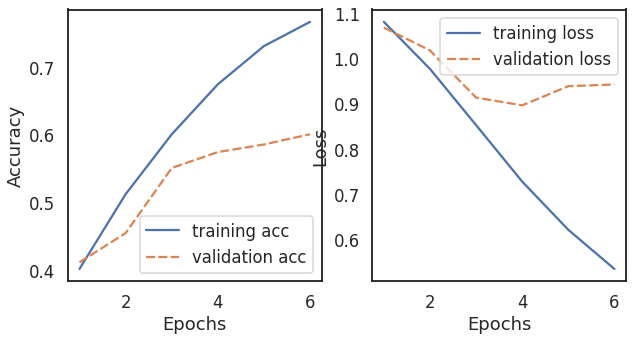

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 2_rep_(tuned)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.085, train_acc:0.395, val Loss: : 1.081227, val_acc: 0.392
[epoch 2] train_loss: 0.991, train_acc:0.499, val Loss: : 0.948620, val_acc: 0.488
[epoch 3] train_loss: 0.876, train_acc:0.586, val Loss: : 0.942509, val_acc: 0.549
[epoch 4] train_loss: 0.772, train_acc:0.646, val Loss: : 0.897665, val_acc: 0.569
[epoch 5] train_loss: 0.681, train_acc:0.697, val Loss: : 0.989609, val_acc: 0.565
[epoch 6] train_loss: 0.605, train_acc:0.734, val Loss: : 0.890401, val_acc: 0.607
[epoch 7] train_loss: 0.543, train_acc:0.765, val Loss: : 0.871238, val_acc: 0.631
[epoch 8] train_loss: 0.489, train_acc:0.791, val Loss: : 1.011801, val_acc: 0.607
[epoch 9] train_loss: 0.442, train_acc:0.814, val Loss: : 0.90380

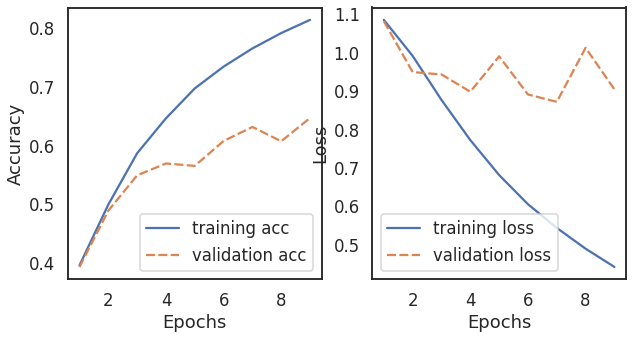

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 3_rep_(tuned)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.085, train_acc:0.397, val Loss: : 1.060293, val_acc: 0.405
[epoch 2] train_loss: 0.987, train_acc:0.505, val Loss: : 1.019469, val_acc: 0.452
[epoch 3] train_loss: 0.867, train_acc:0.591, val Loss: : 0.932443, val_acc: 0.533
[epoch 4] train_loss: 0.759, train_acc:0.658, val Loss: : 0.961780, val_acc: 0.554
[epoch 5] train_loss: 0.665, train_acc:0.707, val Loss: : 0.945649, val_acc: 0.579
[epoch 6] train_loss: 0.589, train_acc:0.744, val Loss: : 0.915841, val_acc: 0.603
[epoch 7] train_loss: 0.520, train_acc:0.776, val Loss: : 0.912048, val_acc: 0.618
[epoch 8] train_loss: 0.460, train_acc:0.800, val Loss: : 0.913961, val_acc: 0.642
[epoch 9] train_loss: 0.403, train_acc:0.828, val Loss: : 0.97422

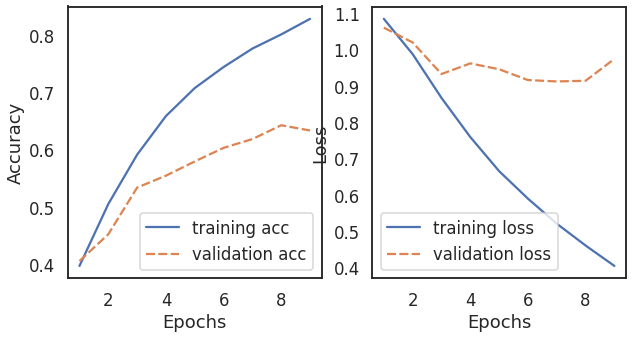

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 4_rep_(tuned)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.072, train_acc:0.425, val Loss: : 1.052911, val_acc: 0.396
[epoch 2] train_loss: 0.933, train_acc:0.524, val Loss: : 0.966868, val_acc: 0.471
[epoch 3] train_loss: 0.825, train_acc:0.593, val Loss: : 0.959879, val_acc: 0.508
[epoch 4] train_loss: 0.737, train_acc:0.645, val Loss: : 0.890894, val_acc: 0.562
[epoch 5] train_loss: 0.660, train_acc:0.691, val Loss: : 0.889691, val_acc: 0.586
[epoch 6] train_loss: 0.593, train_acc:0.728, val Loss: : 0.857163, val_acc: 0.613
[epoch 7] train_loss: 0.539, train_acc:0.758, val Loss: : 0.830487, val_acc: 0.627
[epoch 8] train_loss: 0.488, train_acc:0.782, val Loss: : 0.875265, val_acc: 0.628
[epoch 9] train_loss: 0.440, train_acc:0.807, val Loss: : 0.94994

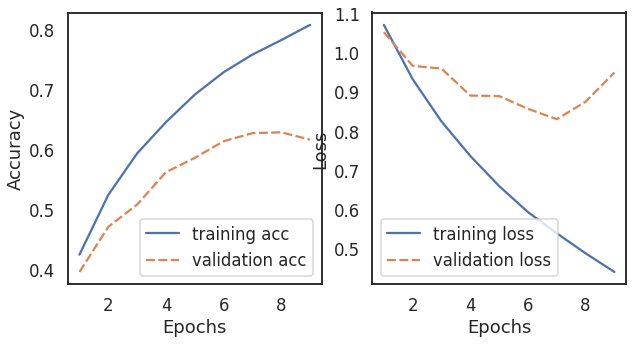

----------------------------------------------------------------------
----------------------------------------------------------------------
Start to make classification use the data : 5_rep_(tuned)
----------------------------------------------------------------------
[epoch 1] train_loss: 1.071, train_acc:0.427, val Loss: : 1.059868, val_acc: 0.411
[epoch 2] train_loss: 0.916, train_acc:0.525, val Loss: : 0.950251, val_acc: 0.453
[epoch 3] train_loss: 0.821, train_acc:0.589, val Loss: : 0.929524, val_acc: 0.526
[epoch 4] train_loss: 0.740, train_acc:0.639, val Loss: : 0.928317, val_acc: 0.551
[epoch 5] train_loss: 0.670, train_acc:0.684, val Loss: : 0.932658, val_acc: 0.575
[epoch 6] train_loss: 0.607, train_acc:0.723, val Loss: : 0.885004, val_acc: 0.604
[epoch 7] train_loss: 0.549, train_acc:0.754, val Loss: : 0.841748, val_acc: 0.624
[epoch 8] train_loss: 0.498, train_acc:0.779, val Loss: : 0.864479, val_acc: 0.619
[epoch 9] train_loss: 0.451, train_acc:0.804, val Loss: : 0.89626

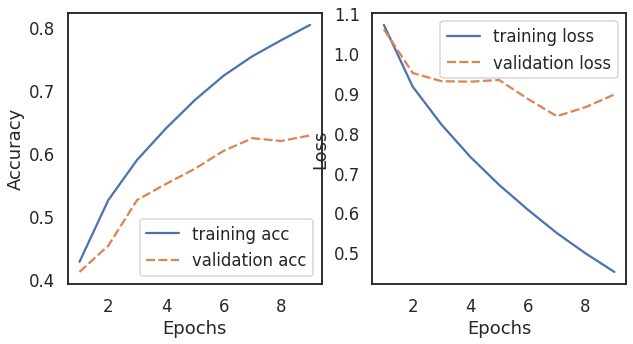

----------------------------------------------------------------------
acc_list [0.6467976467976468, 0.621045621045621, 0.6225996225996226, 0.6449106449106449, 0.645021645021645, 0.6134976134976134]
loss_list [0.8368821740150452, 0.9433193802833557, 1.0138016939163208, 0.9424156546592712, 0.9249622821807861, 0.9963086247444153]
precision_list [array([0.28623188, 0.63148317, 0.70352069]), array([0.26999059, 0.63884331, 0.71433225]), array([0.23957409, 0.65414508, 0.71046154]), array([0.30941704, 0.64211148, 0.6919105 ]), array([0.31105991, 0.62074277, 0.75      ]), array([0.24948665, 0.61456064, 0.75148397])]
recall_list [array([0.11566618, 0.78047683, 0.5871134 ]), array([0.42020498, 0.70062978, 0.56520619]), array([0.39531479, 0.68151147, 0.59510309]), array([0.20204978, 0.73324336, 0.62164948]), array([0.19765739, 0.81578947, 0.52809278]), array([0.35578331, 0.76135852, 0.48943299])]
fscore_list [array([0.16475495, 0.6981189 , 0.64006743]), array([0.32875143, 0.66831152, 0.63107914])

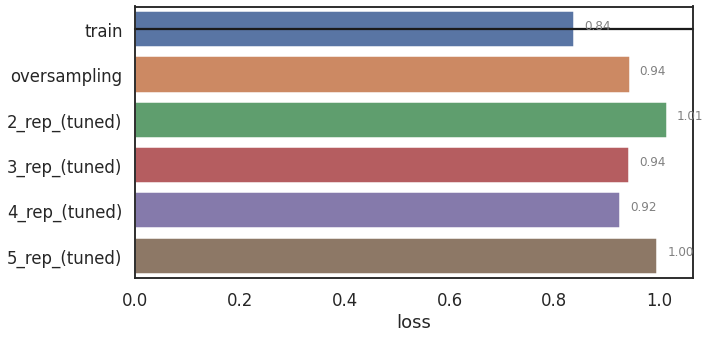

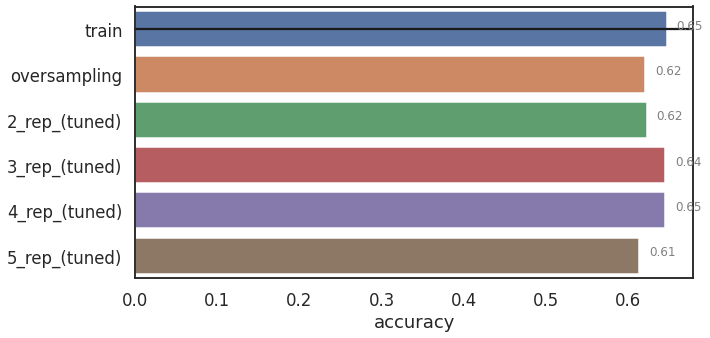

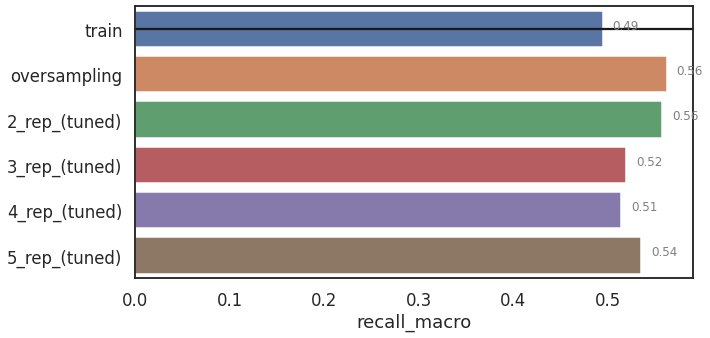

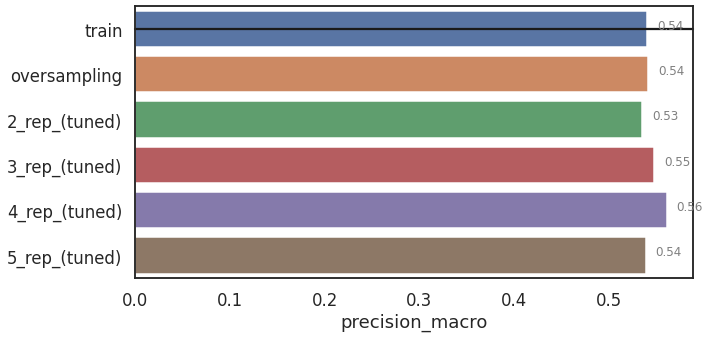

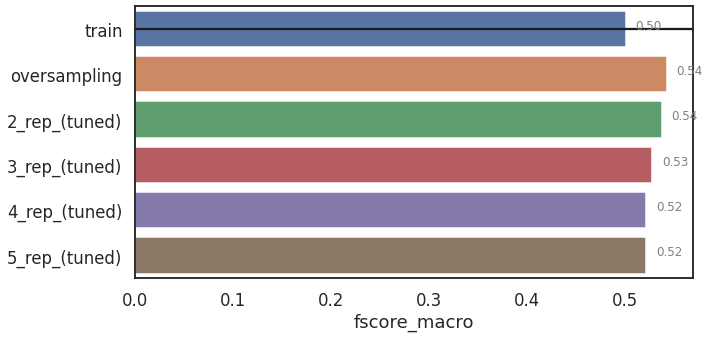

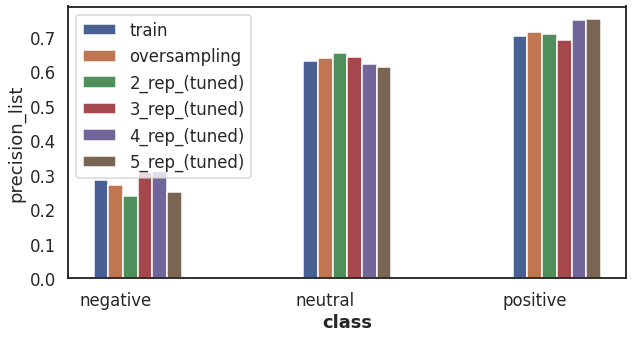

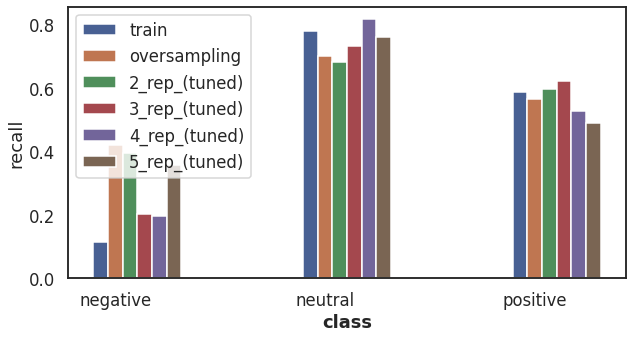

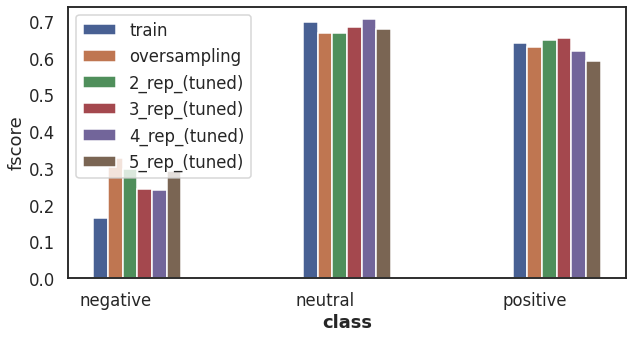

In [13]:
## fine tuned data aug, the result of the test data 

task_name = 'sub_twitter'
tech_name = 'Bert_ data augmentation-master'
test_list = [
      'train',
      # 'backtrans'
      'oversampling',
      '2_rep_(tuned)',
      '3_rep_(tuned)',
      '4_rep_(tuned)',
      '5_rep_(tuned)',
      # '6_rep_(tuned)',
      
      ]

Execute(test_list, task_name, tech_name)